<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=170 style="padding: 10px"> 
<b>Little Demo: Light curves</b> <br>
Contact author(s): Ryan Lau <br>
Last verified to run: 2023-04-27 <br>
LSST Science Pipelines version: Weekly 2023_07 <br>
Container Size: medium

Let's plot a light curve and do a Lomb-Scargle periodogram analysis on an RR Lyrae variable. This is a truncated version of the DP0.2 tutorial notebook 07b, "Variable Stars in DP0.2"

## 1. Setup and Package Imports

In [68]:
# General
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# Astropy
import astropy.units as u
from astropy.timeseries import LombScargle

# LSST package for TAP queries
from lsst.rsp import get_tap_service

Set up some plotting defaults so plots will look nice:

In [71]:
%matplotlib inline

params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Start the TAP service, which we will use for all data retrieval in this notebook:

In [19]:
service = get_tap_service()

## 2. Create a Lightcurve for a Known RR Lyrae Variable

Set the object ID of a known RR Lyrae variable in the `ForcedSource` table and run a search to get the forced source photometry.

In [65]:
sel_objid = 1651589610221899038

# Define the query
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "

results = service.search(query)
srcs = results.to_table()
del query


Uncomment and execute the following cell to see what this table looks like.

In [49]:
#srcs

Plot the lightcurve of the variable in all (ugrizy) filters.

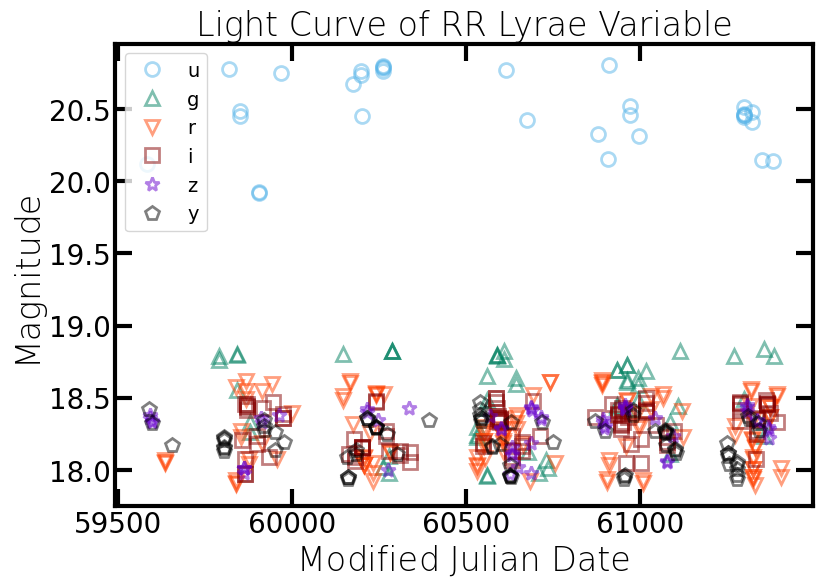

In [63]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (srcs['band'] == filter)

fig, ax = plt.subplots(figsize=(9,6))
    
for filter in plot_filter_labels:
    ax.plot(srcs[pick[filter]]['expMidptMJD'], srcs[pick[filter]]['psfMag'],
    plot_filter_symbols[filter], ms=10, mew=2, mec=plot_filter_colors[filter],
    alpha=0.5, color='none', label=filter)

ax.set_xlabel('Modified Julian Date')
ax.set_ylabel('Magnitude')
ax.set_title('Light Curve of RR Lyrae Variable')
ax.legend(loc='upper left', ncol=1)

plt.show()

## 3 Create a Phased Lightcurve

First, we will extract a periodogram. We start off by defining the parameters of the Lomb-Scargle periodogram analysis.

In [72]:
mjd_days = {}
mags = {}
for filter in plot_filter_labels:
    mjd_days[filter] = np.array(srcs[pick[filter]]['expMidptMJD']) * u.day
    mags[filter] = np.array(srcs[pick[filter]]['psfMag'])
    
    
min_period = 0.05 * u.day
max_period = 1.05 * u.day

min_freq_search = 1.0 / max_period
max_freq_search = 1.0 / min_period

Now we run the Lomb-Scargle algorithm the photometry of each filter. We will set only the min/max frequencies, and otherwise use the "autopower" method from Lomb-Scargle. 

In [73]:
frequency = {}
power = {}
for filter in plot_filter_labels:
    frequency[filter], power[filter] =\
        LombScargle(mjd_days[filter], mags[filter]).autopower(minimum_frequency=min_freq_search,
                                                              maximum_frequency=max_freq_search)
    
all_peak_freqs = []

for filter in plot_filter_labels:
    # find the index with maximum power (= peakbin)
    peakbin = np.argmax(power[filter])

    # Store the frequency corresponding to the peak power in each filter (band)
    all_peak_freqs.append(frequency[filter][peakbin].value)

# Convert the frequencies from a list to and array:
all_peak_freqs = np.array(all_peak_freqs)

# Calculate the mean of the "best-fit" frequencies:
mean_peak_freq = np.mean(all_peak_freqs)
best_period = 1/mean_peak_freq

print('Mean frequency:', mean_peak_freq)
print('Mean period:', best_period, ' days')
print('\nugrizy frequency results:\n', all_peak_freqs)


Mean frequency: 1.962589383860051
Mean period: 0.5095309330743371  days

ugrizy frequency results:
 [1.96261051 1.96261062 1.96261288 1.96252393 1.96255106 1.9626273 ]


To "phase" the lightcurves, we calculate how many periods have passed since some fiducial time "t0". Here, we select t0 to be the time of the first g-band observation, but that is completely arbitrary.

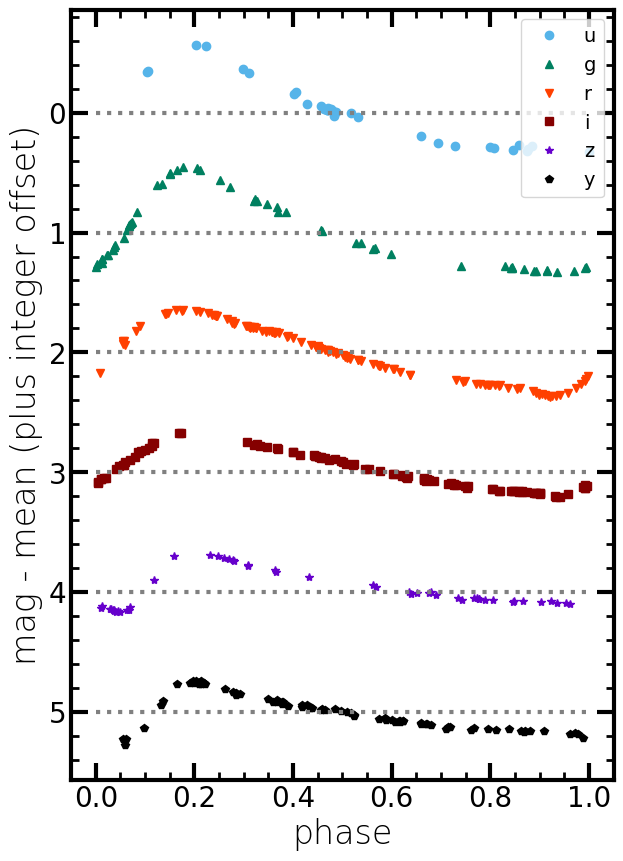

In [74]:
mjd_norm = {}
phase = {}

# Number of elapsed periods since the first measurement:
t0 = np.min(mjd_days['g'].value)

for filter in plot_filter_labels:
    mjd_norm[filter] = (mjd_days[filter].value - t0) / best_period

    # Calculate phase by using the modulus function:
    phase[filter] = np.mod(mjd_norm[filter], 1.0)
    
fig = plt.figure(figsize=(7, 10))     # create a matplotlib.pyplot figure

i = 0

for filter in plot_filter_labels:
    plt.plot(phase[filter], mags[filter]-np.mean(mags[filter]) + i,
             plot_filter_symbols[filter],
             color=plot_filter_colors[filter], label=filter)
    plt.hlines(i, 0, 1, linestyle=':', color='Gray')
    i += 1

plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean (plus integer offset)')
plt.minorticks_on()
plt.show()